In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Load data and convert to PyTorch tensor
data = pd.read_excel('Death-self-cl.xlsx')




In [2]:
data

,Year,Vietnam,Thailand,Laos,Cambodia,Myanmar
0,1990,6946,6986,583,689,2987
1,1991,6993,7411,593,709,2929
2,1992,7021,7755,603,739,2899
3,1993,7046,8314,611,774,2892
4,1994,7054,9073,615,803,2951
5,1995,7081,9942,617,820,3113
6,1996,7067,10627,609,825,3079
7,1997,7043,9819,601,828,3034
8,1998,7026,9546,593,832,2929
9,1999,6992,9885,580,829,3162


In [3]:
columns = ['Year', 'Vietnam', 'Thailand', 'Laos', 'Cambodia', 'Myanmar']
data = data[columns]

# Define the input and output columns
input_cols = ['Year']
output_cols = ['Vietnam', 'Thailand', 'Laos', 'Cambodia', 'Myanmar']

# Split the data into training and testing sets
train_data = data[data['Year'] <= 2014]
test_data = data[ data['Year'] >= 2015]


In [4]:
train_data.shape

(25, 6)

In [5]:
test_data.shape

(5, 6)

Epoch [1/20000], Training Loss: 1.0427
Epoch [2/20000], Training Loss: 0.9508
Epoch [3/20000], Training Loss: 0.9478
Epoch [4/20000], Training Loss: 0.9370
Epoch [5/20000], Training Loss: 0.9990
Epoch [6/20000], Training Loss: 0.9920
Epoch [7/20000], Training Loss: 0.9333
Epoch [8/20000], Training Loss: 0.9531
Epoch [9/20000], Training Loss: 0.9682
Epoch [10/20000], Training Loss: 0.9529
Epoch [11/20000], Training Loss: 0.8954
Epoch [12/20000], Training Loss: 0.9489
Epoch [13/20000], Training Loss: 0.9165
Epoch [14/20000], Training Loss: 0.9495
Epoch [15/20000], Training Loss: 1.0261
Epoch [16/20000], Training Loss: 0.8804
Epoch [17/20000], Training Loss: 0.9507
Epoch [18/20000], Training Loss: 0.9536
Epoch [19/20000], Training Loss: 0.9769
Epoch [20/20000], Training Loss: 0.9979
Epoch [21/20000], Training Loss: 0.9469
Epoch [22/20000], Training Loss: 0.9615
Epoch [23/20000], Training Loss: 0.9544
Epoch [24/20000], Training Loss: 1.0246
Epoch [25/20000], Training Loss: 0.9287
Epoch [26

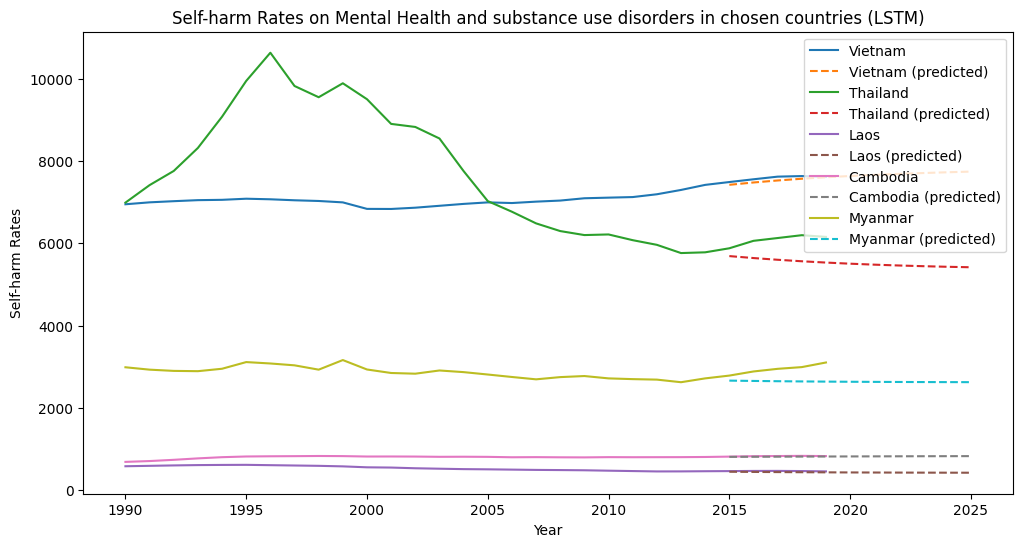

In [6]:
# Normalize the data
train_mean = train_data.mean()
train_std = train_data.std()
train_data = (train_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

# Define the model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.linear(lstm_out[:, -1, :])
        return out

# Define the hyperparameters
learning_rate = 0.01
num_epochs = 20000
batch_size = 16
hidden_dim = 32

# Initialize the model
model = LSTMModel(len(input_cols), hidden_dim, len(output_cols))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define the training loop
train_losses = []
for epoch in range(num_epochs):
    batch_losses = []
    # Shuffle the data
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    # Split the data into batches
    for i in range(0, len(train_data), batch_size):
        batch_data = train_data[i:i+batch_size]
        # Extract the input and output data
        x_batch = torch.tensor(batch_data[input_cols].values, dtype=torch.float32).unsqueeze(1)
        y_batch = torch.tensor(batch_data[output_cols].values, dtype=torch.float32)
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}')

# Prepare the input data
input_data = np.arange(2015, 2026).reshape(-1, 1)
input_data = (input_data - train_mean['Year']) / train_std['Year']
input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

# Predict the output
with torch.no_grad():
    model.eval()
    output_data = model(input_data)
output_data = output_data.detach().numpy()

# Convert the output data back to original scale
output_data = (output_data * train_std[output_cols].values) + train_mean[output_cols].values

import matplotlib.pyplot as plt
import numpy as np

# Plot the predicted output
plt.figure(figsize=(12, 6))
for i, col in enumerate(output_cols):
    plt.plot(data['Year'].values, data[col].values, label=col)
    plt.plot(np.arange(2015, 2026), output_data[:, i], label=col + ' (predicted)', linestyle='--')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Self-harm Rates')
plt.title('Self-harm Rates on Mental Health and substance use disorders in chosen countries (LSTM)')
plt.show()


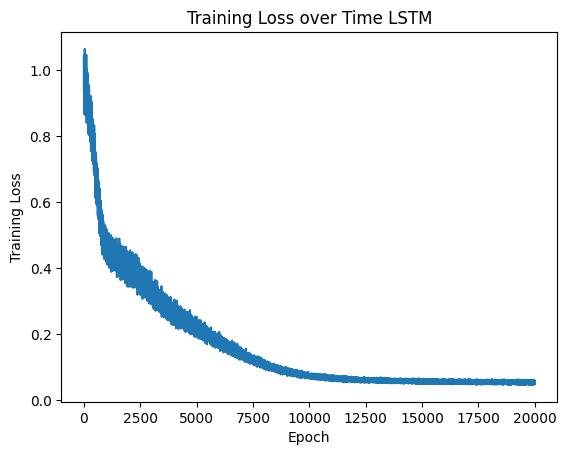

In [7]:
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Time LSTM')
plt.show()

In [8]:
# Predict the output on test data
with torch.no_grad():
    model.eval()
    test_inputs = torch.tensor(test_data[input_cols].values, dtype=torch.float32).unsqueeze(1)
    test_outputs = torch.tensor(test_data[output_cols].values, dtype=torch.float32)
    test_predictions = model(test_inputs)
    test_loss = criterion(test_predictions, test_outputs)
print(f'Test Loss: {test_loss:.4f}')


Test Loss: 1.1066
